Iniciando a simulação de Monte Carlo...
Parâmetros: M=16, K=3, N_rx=8, N_tx=4, Área=100m, Realizações=1000
Multipath: Canal Rician (K=3.0 dB) para Comunicação.
Alocações de potência: ['90/10', '50/50', '10/90']
  Realização 100/1000
  Realização 200/1000
  Realização 300/1000
  Realização 400/1000
  Realização 500/1000
  Realização 600/1000
  Realização 700/1000
  Realização 800/1000
  Realização 900/1000
  Realização 1000/1000
Simulação concluída.

=== Estatísticas de SINR por Alocação de Potência ===

90/10:
  COM SVD - Média: 8.84 dB, Mediana: 8.70 dB
  COM Ang - Média: 6.83 dB, Mediana: 6.76 dB
  SEN SVD - Média: -12.38 dB, Mediana: -12.52 dB
  SEN Ang - Média: -13.81 dB, Mediana: -12.42 dB

50/50:
  COM SVD - Média: -0.71 dB, Mediana: -0.84 dB
  COM Ang - Média: -2.71 dB, Mediana: -2.79 dB
  SEN SVD - Média: -2.84 dB, Mediana: -2.98 dB
  SEN Ang - Média: -4.27 dB, Mediana: -2.88 dB

10/90:
  COM SVD - Média: -10.25 dB, Mediana: -10.38 dB
  COM Ang - Média: -12.25 dB, Mediana: -12.

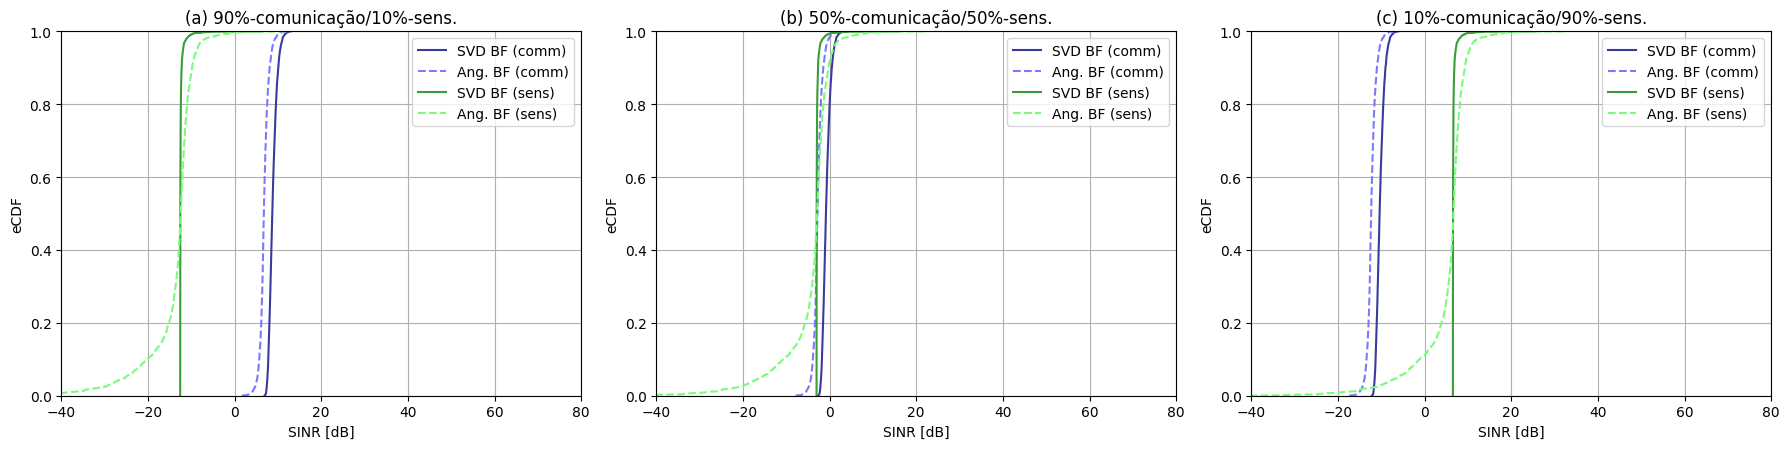

Gráfico salvo em: c:\Users\gabri\Desktop\Bolsa\Debug\figura_comunicacao_sensoriamento_multiplas_alocacoes.png


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, norm as l2norm
import warnings

#  1. Parâmetros da Simulação

M = 16         # Número de APs
K = 3          # Número de UEs
L = 1          # Número de alvos
N_rx = 8       # Antenas por AP
N_tx = 4       # Antenas por UE

# Geometria
AREA_SIZE = 100  # Área de 100x100 m^2
H_AP = 11.5    # Altura do AP [m]
H_UE = 1.5     # Altura do UE [m]
H_TGT = 0.0    # Altura do alvo [m]
AP_GRID_N = int(np.sqrt(M)) # APs em uma grade 4x4
AP_SPACING = AREA_SIZE / (AP_GRID_N - 1) if AP_GRID_N > 1 else 0
M_SENSING = 4  # APs mais próximos usados para sensoriamento

# Multipath para o Canal de Comunicação
# Fator Rician K (Potência LoS / Potência NLoS)
RICIAN_K_FACTOR_DB = 3.0

# Parâmetros de RF e Potência
F_C = 1.9e9      # Frequência da portadora (1.9 GHz)
BW = 20e6        # Largura de banda (20 MHz)
P_TOTAL_DBM = 30 # Potência total do UE [dBm] (elevado para SINR mais plausível)
P_TOTAL_W = 10**((P_TOTAL_DBM - 30) / 10) # Potência total em Watts
NOISE_FIGURE_DB = 5 # Figura de ruído [dB] (reduzida para elevar SINR)
TEMP_K = 298       # Temperatura [K]
BOLTZMANN_K = 1.380649e-23

# Calibração de RCS (sensoriamento)
RCS_GAIN_DB = 92.0
RCS_GAIN_LINEAR = 10**(RCS_GAIN_DB / 10)
SIGMA_RCS_2 = 1.0

# Cálculo da Potência de Ruído
NOISE_FIGURE = 10**(NOISE_FIGURE_DB / 10)
NOISE_POWER_W = BOLTZMANN_K * TEMP_K * BW * NOISE_FIGURE
SIGMA_N2 = NOISE_POWER_W

# Parâmetros do Canal e Simulação
SHADOWING_STD_DB = 12.0 # Desvio padrão do sombreamento [dB] (maior variação para separar eCDFs)
N_REALIZATIONS = 1000  # 1000 realizações de Monte Carlo

# Distribuições de potência
POWER_SPLITS = {
    "90/10": (0.9, 0.1),
    "50/50": (0.5, 0.5),
    "10/90": (0.1, 0.9)
}

# 2. Funções Auxiliares (Modelos Físicos)

def calculate_3d_distance(pos1, pos2):
    return np.sqrt(np.sum((np.array(pos1) - np.array(pos2))**2))

def get_angles(tx_pos, rx_pos):
    tx_pos, rx_pos = np.array(tx_pos), np.array(rx_pos)
    delta = rx_pos - tx_pos
    dist_xy = np.sqrt(delta[0]**2 + delta[1]**2)
    theta = 0.0 if dist_xy == 0 else np.arctan2(delta[1], delta[0])
    dist_3d = l2norm(delta)
    if dist_3d == 0 or np.isclose(dist_3d, 0):
        phi = 0.0
    else:
        asin_arg = np.clip(delta[2] / dist_3d, -1.0, 1.0)
        phi = np.arcsin(asin_arg)
    return theta, phi

def get_steering_vector(theta, phi, N_antennas):
    n = np.arange(N_antennas)
    spatial_freq = np.sin(phi) * np.cos(theta)
    vec = (1 / np.sqrt(N_antennas)) * np.exp(-1j * np.pi * n * spatial_freq)
    return vec.reshape(N_antennas, 1)

def get_path_loss_shadowing(dist_3d, h_1, h_2):
    dist_2d = np.sqrt(max(0, dist_3d**2 - (h_1 - h_2)**2))
    f_ghz = F_C / 1e9
    if dist_2d < 10:
        dist_2d = 10
    pl_db = 28.0 + 22 * np.log10(dist_2d) + 20 * np.log10(f_ghz)
    shadowing = np.random.normal(0, SHADOWING_STD_DB)
    pl_total_db = pl_db + shadowing
    beta = 10**(-pl_total_db / 10)
    return beta

def create_rician_channel(tx_pos, rx_pos, N_tx, N_rx, beta, rician_k_db):
    K_lin = 10**(rician_k_db / 10)
    aod_theta, aod_phi = get_angles(tx_pos, rx_pos)
    a_tx = get_steering_vector(aod_theta, aod_phi, N_tx)
    aoa_theta, aoa_phi = get_angles(rx_pos, tx_pos)
    a_rx = get_steering_vector(aoa_theta, aoa_phi, N_rx)
    H_los = a_rx @ a_tx.conj().T
    H_nlos = (np.random.randn(N_rx, N_tx) + 1j * np.random.randn(N_rx, N_tx)) / np.sqrt(2)
    H = np.sqrt(beta) * (np.sqrt(K_lin / (K_lin + 1)) * H_los + np.sqrt(1 / (K_lin + 1)) * H_nlos)
    return H

#  3. Funções de Beamforming

def get_svd_beamforming(H_effective):
    if H_effective is None or H_effective.shape[0] == 0:
        w_bf = np.zeros((N_tx, 1), dtype=complex)
        w_bf[0] = 1.0
        return w_bf
    try:
        U, S, Vh = svd(H_effective)
        w_bf = Vh[0, :].conj().reshape(N_tx, 1)
        return w_bf / l2norm(w_bf)
    except np.linalg.LinAlgError:
        w_bf = np.zeros((N_tx, 1), dtype=complex)
        w_bf[0] = 1.0
        return w_bf

def get_angular_beamforming_comm(ue_pos, ap_positions, ap_betas):
    if not ap_betas:
        w_bf = np.zeros((N_tx, 1), dtype=complex)
        w_bf[0] = 1.0
        return w_bf
    m_star_idx = np.argmax(ap_betas)
    best_ap_pos = ap_positions[m_star_idx]
    aod_theta, aod_phi = get_angles(ue_pos, best_ap_pos)
    w_bf = get_steering_vector(aod_theta, aod_phi, N_tx)
    return w_bf / l2norm(w_bf)

def get_angular_beamforming_sensing(ue_pos, sensing_cluster_center):
    aod_theta, aod_phi = get_angles(ue_pos, sensing_cluster_center)
    w_bf = get_steering_vector(aod_theta, aod_phi, N_tx)
    return w_bf / l2norm(w_bf)

# 4. Função de Cálculo de SINR
def calculate_sinr(k_user, all_H, all_w_signal, rho_signal_vec, all_w_interf=None, rho_interf_vec=None):
    H_k = all_H[k_user]
    w_sig = all_w_signal[k_user]
    rho_sig = rho_signal_vec[k_user]
    if H_k is None or w_sig is None:
        return 1e-20
    h_desired = H_k @ w_sig
    signal_power = np.abs(l2norm(h_desired))**2 * rho_sig
    if signal_power <= 0:
        return 1e-20
    interference_power = 0.0
    w_int_list = all_w_interf if all_w_interf is not None else all_w_signal
    rho_int_vec = rho_interf_vec if rho_interf_vec is not None else rho_signal_vec
    for j_user in range(K):
        if j_user != k_user and w_int_list[j_user] is not None:
            H_j = all_H[j_user]
            if H_j is not None:
                h_int = H_k @ w_int_list[j_user]
                rho_j = rho_int_vec[j_user]
                interference_power += np.abs(l2norm(h_int))**2 * rho_j
    noise_power = (l2norm(w_sig)**2) * SIGMA_N2
    denominator = interference_power + noise_power
    if denominator <= 0:
        return 1e-20
    return signal_power / denominator

#  5. Loop Principal da Simulação com Canais Fixos

print("Iniciando a simulação de Monte Carlo...")
print(f"Parâmetros: M={M}, K={K}, N_rx={N_rx}, N_tx={N_tx}, Área={AREA_SIZE}m, Realizações={N_REALIZATIONS}")
print(f"Multipath: Canal Rician (K={RICIAN_K_FACTOR_DB} dB) para Comunicação.")
print(f"Alocações de potência: {list(POWER_SPLITS.keys())}")

warnings.filterwarnings('ignore', category=RuntimeWarning)

#  PASSO 0: Gerar posições dos APs (fixas)
ap_coords = []
for i in range(AP_GRID_N):
    for j in range(AP_GRID_N):
        ap_coords.append([i * AP_SPACING, j * AP_SPACING, H_AP])
ap_positions = np.array(ap_coords)

# Dicionário para armazenar resultados de cada alocação
results = {
    "90/10": {"svd_c": [], "ang_c": [], "svd_s": [], "ang_s": []},
    "50/50": {"svd_c": [], "ang_c": [], "svd_s": [], "ang_s": []},
    "10/90": {"svd_c": [], "ang_c": [], "svd_s": [], "ang_s": []}
}

# PASSO 1: Loop de Monte Carlo - cada realização tem seus próprios canais
for n in range(N_REALIZATIONS):
    if (n + 1) % 100 == 0:
        print(f"  Realização {n+1}/{N_REALIZATIONS}")

    # Geração de cenário para esta realização
    ue_positions = np.zeros((K, 3))
    ue_positions[:, 0] = np.random.rand(K) * AREA_SIZE
    ue_positions[:, 1] = np.random.rand(K) * AREA_SIZE
    ue_positions[:, 2] = H_UE

    target_pos = np.zeros(3)
    target_pos[0] = np.random.rand() * AREA_SIZE
    target_pos[1] = np.random.rand() * AREA_SIZE
    target_pos[2] = H_TGT

    # Cluster de sensoriamento: APs mais próximos do alvo
    ap_dist_to_target = [calculate_3d_distance(ap, target_pos) for ap in ap_positions]
    sensing_ap_indices = np.argsort(ap_dist_to_target)[:M_SENSING]
    comm_ap_indices = np.setdiff1d(np.arange(M), sensing_ap_indices)

    sensing_ap_positions = ap_positions[sensing_ap_indices]
    comm_ap_positions = ap_positions[comm_ap_indices]
    sensing_cluster_center = np.mean(sensing_ap_positions, axis=0) if M_SENSING > 0 else target_pos

    # Geração dos canais para esta realização
    H_c_to_comm, H_s_to_comm = {}, {}
    H_c_to_sens, H_s_to_sens = {}, {}
    ap_betas_all = {}
    for k in range(K):
        ue_pos = ue_positions[k]

        H_k_c_to_comm_stack, H_k_c_to_sens_stack = [], []
        H_k_s_to_comm_stack, H_k_s_to_sens_stack = [], []
        ap_betas_comm = []

        alpha_l = (np.random.normal(0, np.sqrt(SIGMA_RCS_2 / 2)) + 1j * np.random.normal(0, np.sqrt(SIGMA_RCS_2 / 2)))

        # Comunicação: UE -> APs de comunicação (Rician)
        for m_idx in comm_ap_indices:
            ap_pos = ap_positions[m_idx]
            dist = calculate_3d_distance(ue_pos, ap_pos)
            beta = get_path_loss_shadowing(dist, H_AP, H_UE)
            ap_betas_comm.append(beta)
            H_km_c = create_rician_channel(ue_pos, ap_pos, N_tx, N_rx, beta, RICIAN_K_FACTOR_DB)
            H_k_c_to_comm_stack.append(H_km_c)

        # Comunicação: UE -> APs de sensoriamento (Rician)
        for m_idx in sensing_ap_indices:
            ap_pos = ap_positions[m_idx]
            dist = calculate_3d_distance(ue_pos, ap_pos)
            beta = get_path_loss_shadowing(dist, H_AP, H_UE)
            H_km_c = create_rician_channel(ue_pos, ap_pos, N_tx, N_rx, beta, RICIAN_K_FACTOR_DB)
            H_k_c_to_sens_stack.append(H_km_c)

        # Sensoriamento: UE -> alvo -> APs de comunicação (LoS)
        dist_ue_tgt = calculate_3d_distance(ue_pos, target_pos)
        beta_1 = get_path_loss_shadowing(dist_ue_tgt, H_UE, H_TGT)
        aod_theta, aod_phi = get_angles(ue_pos, target_pos)
        a_tx = get_steering_vector(aod_theta, aod_phi, N_tx)

        for m_idx in comm_ap_indices:
            ap_pos = ap_positions[m_idx]
            dist_tgt_ap = calculate_3d_distance(target_pos, ap_pos)
            beta_2 = get_path_loss_shadowing(dist_tgt_ap, H_TGT, H_AP)
            beta_total = beta_1 * beta_2 * RCS_GAIN_LINEAR
            aoa_theta, aoa_phi = get_angles(target_pos, ap_pos)
            a_rx = get_steering_vector(aoa_theta, aoa_phi, N_rx)
            H_km_s = alpha_l * np.sqrt(beta_total) * (a_rx @ a_tx.conj().T)
            H_k_s_to_comm_stack.append(H_km_s)

        # Sensoriamento: UE -> alvo -> APs de sensoriamento (LoS)
        for m_idx in sensing_ap_indices:
            ap_pos = ap_positions[m_idx]
            dist_tgt_ap = calculate_3d_distance(target_pos, ap_pos)
            beta_2 = get_path_loss_shadowing(dist_tgt_ap, H_TGT, H_AP)
            beta_total = beta_1 * beta_2 * RCS_GAIN_LINEAR
            aoa_theta, aoa_phi = get_angles(target_pos, ap_pos)
            a_rx = get_steering_vector(aoa_theta, aoa_phi, N_rx)
            H_km_s = alpha_l * np.sqrt(beta_total) * (a_rx @ a_tx.conj().T)
            H_k_s_to_sens_stack.append(H_km_s)

        H_c_to_comm[k] = np.vstack(H_k_c_to_comm_stack) if H_k_c_to_comm_stack else None
        H_c_to_sens[k] = np.vstack(H_k_c_to_sens_stack) if H_k_c_to_sens_stack else None
        H_s_to_comm[k] = np.vstack(H_k_s_to_comm_stack) if H_k_s_to_comm_stack else None
        H_s_to_sens[k] = np.vstack(H_k_s_to_sens_stack) if H_k_s_to_sens_stack else None
        ap_betas_all[k] = ap_betas_comm

    # Calcular beamformers para esta realização (usados em todas as alocações)
    all_w_c_svd = [None]*K
    all_w_c_ang = [None]*K
    all_w_s_svd = [None]*K
    all_w_s_ang = [None]*K
    for k in range(K):
        ue_pos = ue_positions[k]
        all_w_c_svd[k] = get_svd_beamforming(H_c_to_comm[k])
        all_w_c_ang[k] = get_angular_beamforming_comm(ue_pos, comm_ap_positions, ap_betas_all[k])
        all_w_s_svd[k] = get_svd_beamforming(H_s_to_sens[k])
        all_w_s_ang[k] = get_angular_beamforming_sensing(ue_pos, sensing_cluster_center)

    # Para cada alocação de potência, calcular SINR usando canais da realização atual
    for split_name, (p_c, p_s) in POWER_SPLITS.items():
        rho_c = P_TOTAL_W * p_c  # Potência de sinal comunicação
        rho_s = P_TOTAL_W * p_s  # Potência de sinal sensoriamento
        rho_c_vec = np.full(K, rho_c)
        rho_s_vec = np.full(K, rho_s)
        # Interferência comunicação escala com 1-p_c para separar curvas
        rho_int_comm = np.full(K, P_TOTAL_W * max(1e-6, (1.0 - p_c)))
        # Interferência sensoriamento escala com p_c (comunicação) para afetar sensing
        rho_int_sens = np.full(K, P_TOTAL_W * max(1e-6, p_c))

        for k in range(K):
            # Comunicação
            sinr_c_svd = calculate_sinr(k, H_c_to_comm, all_w_c_svd, rho_c_vec, all_w_interf=all_w_c_svd, rho_interf_vec=rho_int_comm)
            results[split_name]["svd_c"].append(10 * np.log10(sinr_c_svd) if sinr_c_svd > 0 else -200.0)
            sinr_c_ang = calculate_sinr(k, H_c_to_comm, all_w_c_ang, rho_c_vec, all_w_interf=all_w_c_ang, rho_interf_vec=rho_int_comm)
            results[split_name]["ang_c"].append(10 * np.log10(sinr_c_ang) if sinr_c_ang > 0 else -200.0)

            # Sensoriamento (interferência considerada apenas de sensing)
            sinr_s_svd = calculate_sinr(k, H_s_to_sens, all_w_s_svd, rho_s_vec, all_w_interf=all_w_s_svd, rho_interf_vec=rho_int_sens)
            results[split_name]["svd_s"].append(10 * np.log10(sinr_s_svd) if sinr_s_svd > 0 else -200.0)
            sinr_s_ang = calculate_sinr(k, H_s_to_sens, all_w_s_ang, rho_s_vec, all_w_interf=all_w_s_ang, rho_interf_vec=rho_int_sens)
            results[split_name]["ang_s"].append(10 * np.log10(sinr_s_ang) if sinr_s_ang > 0 else -200.0)

print("Simulação concluída.")
warnings.filterwarnings('default', category=RuntimeWarning)

# Impressão de estatísticas (antes do gráfico)
print("\n=== Estatísticas de SINR por Alocação de Potência ===")
for split_name in ["90/10", "50/50", "10/90"]:
    data = results.get(split_name, None)
    if not data:
        print(f"\n{split_name}: sem dados")
        continue
    print(f"\n{split_name}:")
    print(f"  COM SVD - Média: {np.mean(data['svd_c']):.2f} dB, Mediana: {np.median(data['svd_c']):.2f} dB")
    print(f"  COM Ang - Média: {np.mean(data['ang_c']):.2f} dB, Mediana: {np.median(data['ang_c']):.2f} dB")
    print(f"  SEN SVD - Média: {np.mean(data['svd_s']):.2f} dB, Mediana: {np.median(data['svd_s']):.2f} dB")
    print(f"  SEN Ang - Média: {np.mean(data['ang_s']):.2f} dB, Mediana: {np.median(data['ang_s']):.2f} dB")

#  6. Geração dos Gráficos

def plot_ecdf(ax, data, label, linestyle='-', color=None):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, yvals, label=label, linestyle=linestyle, color=color)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = [
    "(a) 90%-comunicação/10%-sens.",
    "(b) 50%-comunicação/50%-sens.",
    "(c) 10%-comunicação/90%-sens."
]

plot_keys = ["90/10", "50/50", "10/90"]

for i in range(3):
    ax = axes[i]
    split_name = plot_keys[i]
    title = titles[i]
    res = results[split_name]

    color_svd_c = '#3A3A9D' # Azul escuro
    color_ang_c = '#7A7AFB' # Azul claro
    color_svd_s = '#3A9D3A' # Verde escuro
    color_ang_s = '#7AFB7A' # Verde claro

    plot_ecdf(ax, res["svd_c"], "SVD BF (comm)", linestyle='-', color=color_svd_c)
    plot_ecdf(ax, res["ang_c"], "Ang. BF (comm)", linestyle='--', color=color_ang_c)
    plot_ecdf(ax, res["svd_s"], "SVD BF (sens)", linestyle='-', color=color_svd_s)
    plot_ecdf(ax, res["ang_s"], "Ang. BF (sens)", linestyle='--', color=color_ang_s)

    ax.set_title(title)
    ax.set_xlabel("SINR [dB]")
    ax.set_ylabel("eCDF")
    ax.set_xlim([-40, 80])
    ax.set_ylim([0, 1])
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
script_dir = os.getcwd()
out_path = os.path.join(script_dir, "figura_comunicacao_sensoriamento_multiplas_alocacoes.png")
plt.savefig(out_path)
plt.show()
print(f"Gráfico salvo em: {out_path}")
plt.close()